In [1]:
#pip install tensorflow keras opencv-python streamlit numpy pandas scikit-learn matplotlib

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


In [8]:
# Define paths
train_dir = "./chest_xray/chest_xray/train"
test_dir = "./chest_xray/chest_xray/test"
val_dir = "./chest_xray/chest_xray/val"

In [9]:
# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2, shear_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# Calculate steps per epoch and validation steps
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

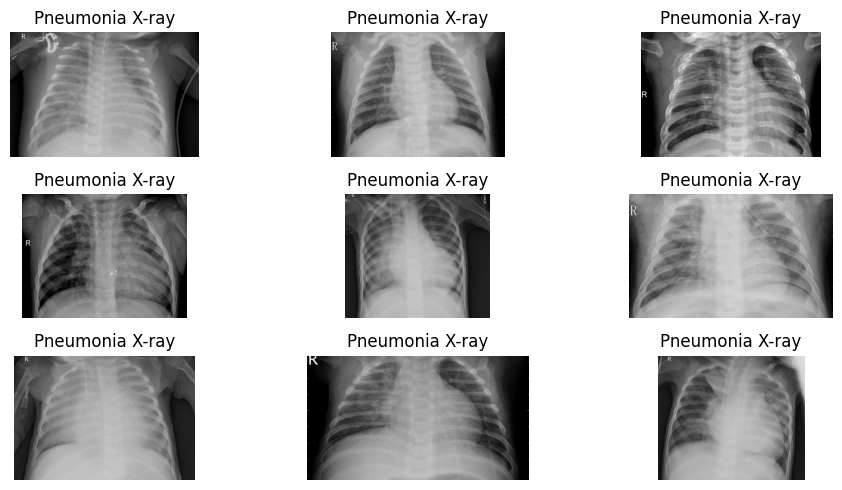

In [7]:
# Visualize sample images
plt.figure(figsize=(10, 5))
pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")
pneumonia_images = os.listdir(pneumonia_dir)[:9]
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

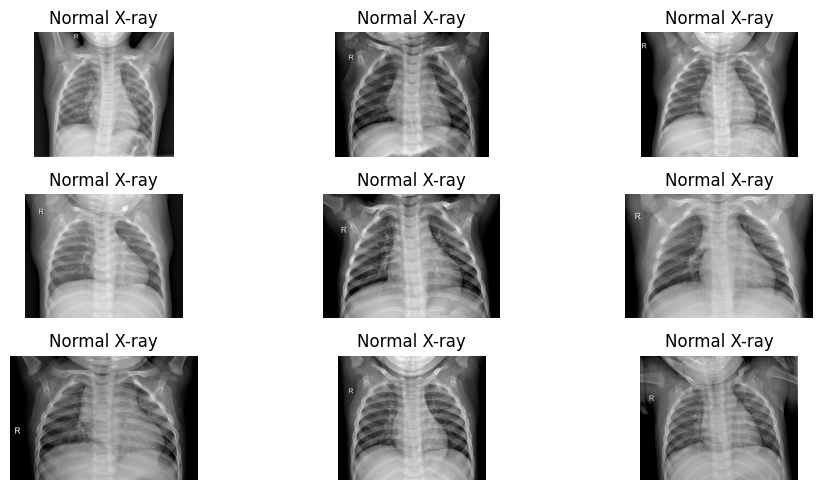

In [8]:
plt.figure(figsize=(10, 5))
normal_dir = os.path.join(train_dir, "NORMAL")
normal_images = os.listdir(normal_dir)[:9]
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

In [12]:
#Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

d:\Pnemonia detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('pneumonia_detection_model.keras', save_best_only=True)

history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=5,validation_data=validation_generator,validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint])


Epoch 1/5


d:\Pnemonia detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.7773 - loss: 0.5511 - val_accuracy: 0.8125 - val_loss: 0.3767
Epoch 2/5


C:\Users\Tanzila\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3767
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 795ms/step - accuracy: 0.9032 - loss: 0.2525 - val_accuracy: 0.6250 - val_loss: 0.6111
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6111
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 802ms/step - accuracy: 0.9218 - loss: 0.2075 - val_accuracy: 0.6875 - val_loss: 0.5398


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - accuracy: 0.7713 - loss: 0.4978
Test Accuracy: 0.84
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       234
           1       0.83      0.93      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.81      0.82       624
weighted avg       0.84      0.84      0.84       624

Confusion Matrix:
[[160  74]
 [ 26 364]]


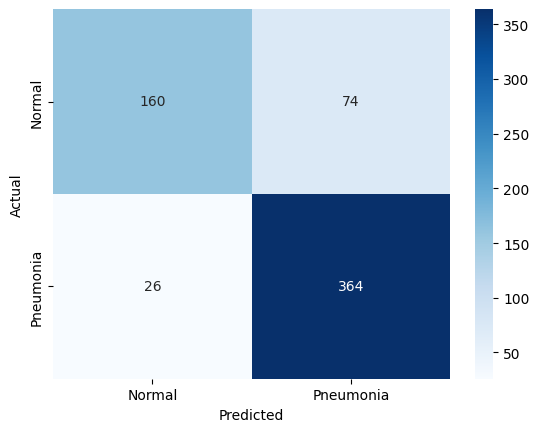

In [21]:
model.load_weights('pneumonia_detection_model.keras')

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.2f}")

# Predict on test data
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.round(y_pred).astype(int)

# Get true labels
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [23]:
model.save('pneumonia_detection_model.h5')